# コミュニティ発見

In [3]:
import numpy as np
import networkx as nx

%matplotlib inline

In [4]:
DRAW_CONFIG = {
    'node_color': 'white',
    'edgecolors': 'black', # line color of nodes
    'with_labels': True,
    'node_size': 600,
    'font_size': 14,
    'font_family': 'Arial',
}

グラフ上では，関係の深いノードの間にエッジが張られる．
グラフがある程度の大きさになると，その内部に意味のある**部分グラフ（subgraph）** ，すなわち**コミュニティ（community）** が形成される．
例えば，以下に示す図は[Twitterユーザ同士のつながりを可視化したグラフ](https://www.carbonbrief.org/mapped-the-climate-change-conversation-on-twitter/)である．
Twitterのようなソーシャルネットワークでは，共通の関心を持つユーザ同士がつながりを持つことで，自然とコミュニティが形成される．

![画像出典: https://www.carbonbrief.org/wp-content/uploads/2016/04/TwitterViz-02-Central-Map.jpg](https://www.carbonbrief.org/wp-content/uploads/2016/04/TwitterViz-02-Central-Map.jpg)

グラフの各ノードにそれが属するコミュニティに関するラベルが付いていれば，苦労はない．
しかし大抵の場合，グラフ分析者に与えられるのは，ノードとノード間の繋がり（エッジ）の情報だけである．
ノードに所属コミュニティに関するメタデータが付いていたとしても，ノードが隠れたコミュニティに属していることもあり得る．
それゆえ，グラフ構造のみに基づきコミュニティを発見する必要が求められる．

以下では，グラフ分析の典型的なタスクの一つである**コミュニティ発見（community detection）** について，基礎となる手法を解説する．

## 連結成分

無向グラフの部分グラフのうち，極大で連結しているものを**連結成分（connected components）** と呼ぶ．
連結成分とは，要するにグラフ中で孤立している部分グラフである．


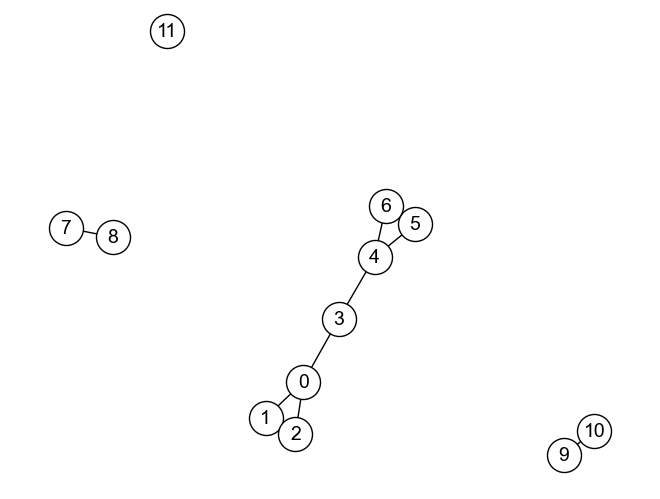

In [3]:
G_unconnected = nx.Graph([
    (0, 1), (0, 2), (0, 3), (1, 2), (3, 4),
    (4, 5), (4, 6), (5, 6),
    (7, 8), (9, 10), 
])
G_unconnected.add_node(11)
pos = nx.spring_layout(G_unconnected, seed=1)
nx.draw(G_unconnected, pos, **DRAW_CONFIG)

例えば，上のグラフ$G_{unconnected}$を見てみよう．
グラフは
- ノード0, 1, 2, 3, 4, 5, 6からなる部分グラフ
- ノード7, 8からなる部分グラフ
- ノード9, 10からなる部分グラフ
- ノード11からなる部分グラフ

から構成されており，それぞれの部分グラフは相互に行き来できず，孤立してしまっている．
そのため，各部分グラフはグラフ$G_{unconnected}$の連結成分と見なす．

NetworkXでグラフの連結成分を抽出するには，`connected_components`関数を用いる．
以下は，上記グラフ$G_{unconnected}$の連結成分を抽出するコードである．

In [4]:
# グラフの定義
G_unconnected = nx.Graph([
    (0, 1), (0, 2), (0, 3), (1, 2), (3, 4),
    (4, 5), (4, 6), (5, 6),
    (7, 8), (9, 10), 
])
G_unconnected.add_node(11)

# connected_components関数の返り値はイテレータなので，結果をリストに変換しておく
list(nx.connected_components(G_unconnected))

[{0, 1, 2, 3, 4, 5, 6}, {7, 8}, {9, 10}, {11}]

## クリーク

連結成分は，グラフ中で孤立している部分グラフしか見つけられない．
実世界では，孤立している部分グラフだけをコミュニティと見なすことは稀である．
様々なノードと繋がるなかで，繋がりが密になっている部分グラフをコミュニティと見なすのが一般的であろう．

**クリーク（clique）** は，グラフの内部で密度が1の極大な部分グラフである．
密度が1のグラフは，グラフ中のすべてのノード間にエッジが張られている．
クリークは，孤立している部分グラフを持たないグラフからコミュニティを発見するための，最も直感的な例である．

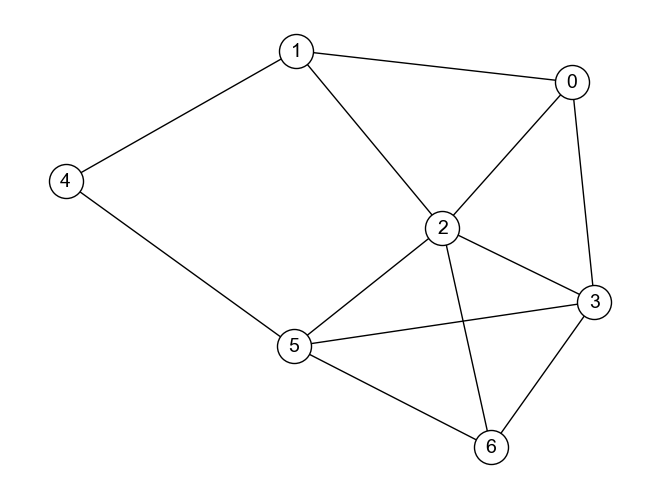

In [5]:
G_clique = nx.Graph([
    (0, 1), (0, 2), (0, 3), 
    (1, 2), (1, 4),
    (2, 3), (2, 5), (2, 6), 
    (3, 5), (3, 6),
    (4, 5),
    (5, 6),
])

pos = nx.spring_layout(G_clique, seed=345)
nx.draw(G_clique, pos, **DRAW_CONFIG)

クリークは，グラフ中に複数存在することがある．
例を見てみよう．
上のグラフ$G_{clique}$において，クリークとなる部分グラフは
- ノード2, 3, 5, 6からなる部分グラフ
- ノード0, 1, 2からなる部分グラフ
- ノード0, 2, 3からなる部分グラフ
- ノード1, 4からなる部分グラフ
- ノード4, 5からなる部分グラフ

の5つである．
なお，上記グラフにおいてノード2, 3, 5からなる部分グラフも密度が1となるが，これはクリークとは見なされない．
定義上，クリークは密度が1の極大な部分グラフである．
ノード2, 3, 5からなる部分グラフはノード2, 3, 5, 6からなるクリークに含まれるため，クリークとは見なされない．

NetworkXでグラフからクリークを抽出するには，`find_cliques`関数を用いる．
以下は，上記グラフ$G_{clique}$からクリークを抽出するコードである．

In [6]:
# グラフの定義
G_clique = nx.Graph([
    (0, 1), (0, 2), (0, 3), 
    (1, 2), (1, 4),
    (2, 3), (2, 5), (2, 6), 
    (3, 5), (3, 6),
    (4, 5),
    (5, 6),
])

# find_cliques関数の返り値はイテレータなので，結果をリストに変換しておく
list(nx.find_cliques(G_clique))

[[2, 1, 0], [2, 3, 0], [2, 3, 5, 6], [4, 1], [4, 5]]

クリーク集合のうち，ノード数が最大となるクリークは**最大クリーク（maximal clique）** と呼ばれる．
上のグラフ$G_{clique}$においては，ノード2, 3, 5, 6からなるクリークが最大クリークとなる．

NetworkXでグラフから最大クリークを抽出するには，`make_max_clique_graph`関数を用いる．
以下は，上記グラフ$G_{clique}$から最大クリークを抽出するコードである．

In [7]:
# 結果をリストに変換しておく
list(nx.make_max_clique_graph(G_clique))

[0, 1, 2, 3, 4]

## グラフ分割

クリークは密度が1となる部分グラフであり，コミュニティの定義としてはかなり厳しい条件を持つ．
実用的には，もう少し緩い密度条件でコミュニティを発見したい．

**グラフ分割（graph partioning）** は，グラフ構造に基づきグラフを意味のある部分グラフに分割し，コミュニティを発見しようとする方法である．
様々なグラフ分割アルゴリズムが提案されているが，ここでは媒介中心性に注目した手法を取り上げる．

### コミュニティ発見のためのグラフ分割の基本アイデア（の1つ）

コミュニティ発見のために，コミュニティとなりえる部分グラフとそうでないものの違いについて，考察しておこう．
下図を見て分かるように，コミュニティとなる部分グラフでは，その内部でノード同士が密に繋がっていることに異論はないであろう．

もう1つ重要な点として，コミュニティ内のノードはコミュニティ外のノードとは比較的つながりが乏しいことが挙げられる．
孤立する部分グラフを持たないグラフにおいて複数のコミュニティが存在するならば，コミュニティ外にあるノードを通じてコミュニティ同士を繋ぐようなエッジが存在しそうである．
そのようなエッジを順次切断することで，グラフをコミュニティに分割できると考えられる．


![](img/how-to-detect-community.jpg)

コミュニティ外にあってコミュニティ同士をつなぐエッジとは，どのようなものだろうか．
上の図を見ると分かるように，そのようなエッジはあるコミュニティから別のコミュニティに移動する際，必ず通ることになりそうである．
言い方を変えると，コミュニティ同士をつなぐエッジは，（異なるコミュニティに属する）多くのノード間の最短経路上に存在しそうである．

ところで，これと似たような話があったことを思い出してほしい．
そう，[ノード中心性の章](](centrality.ipynb))で取り上げた「ノードの媒介中心性」である．

ノードの媒介中心性とは，あるノードがそれ以外のノード間の経路に含まれる割合を示す指標であり，ノードがグラフ上でどの程度「経路上の要所」となっているかを表すものであった．
以下のグラフでは，ノード3の媒介中心性が最大となっており，どこからどこのノードへ最短経路で移動するにせよ，通ることが最も多いノードは3になる．

![](img/betweenness-centrality.jpg)

ノードの媒介中心性が「ノード間の最短経路上に最も頻繁に出現するノード」である．
一方，今私たちが知りたいのは「ノード間の最短経路上に最も頻繁に出現するエッジ」である．
これを見つけるために，ノードの媒介中心性を拝借して，エッジの媒介中心性の概念を導入する．


### エッジの媒介中心性

**エッジの媒介中心性（edge betweenness）** とは，注目エッジがそれ以外のエッジ間の最短経路に含まれる割合である．
あるエッジがグラフ上でどの程度「経路上の要所」となっているかを表す指標である．
計算方法は，ノード媒介中心性の計算において，ノードとエッジの立場をひっくり返して計算するイメージである．

![](img/edge-betweenness.jpg)

NetworkXでエッジの媒介中心性を計算するには，`edge_betweenness_centrality`関数を用いる．
例として以下のグラフ$G_{barbell}$の各エッジの媒介中心性を計算してみよう．

![](img/edge-betweenness-sample.jpg)

計算のためのコードは以下の通りである．

In [8]:
# グラフの定義
G_barbell = nx.barbell_graph(3, 1)

# エッジの媒介中心性の計算
nx.edge_betweenness_centrality(G_barbell)

{(0, 1): 0.047619047619047616,
 (0, 2): 0.23809523809523808,
 (1, 2): 0.23809523809523808,
 (2, 3): 0.5714285714285714,
 (4, 5): 0.23809523809523808,
 (4, 6): 0.23809523809523808,
 (4, 3): 0.5714285714285714,
 (5, 6): 0.047619047619047616}

エッジの媒介中心性が計算できれば，グラフ中で媒介中心性が最大となるエッジを切断すれば，グラフをリンクが密なコミュニティに分割していくことができる．
例えば，上のグラフ$G_{barbell}$において媒介中心性が最大となるエッジは，ノード2と3をつなぐエッジであった．
このエッジを切断すれば，以下の図のように，グラフは2つの部分グラフに分割される．
この結果は，コミュニティの抽出結果としても悪くはなさそうだが，分割されたグラフに対して再度エッジ媒介中心性の計算を行い，中心性が最大となるエッジを削除する操作を繰り返すことで，コミュニティ発見のためのグラフ分割を継続することができる．

![](img/graph-partioning-example.jpg)

### モジュラリティ

エッジの媒介中心性に基づくエッジの切断を行うことでグラフ分割が可能となるが，グラフ分割をどこまで繰り返せば適切な粒度のコミュニティを抽出できるのだろうか．
すなわち，グラフ分割の適切性はどのように評価すれば良いのだろうか．

グラフ分割の適切性評価によく用いられる指標の一つが**モジュラリティ（modularity）** である．
モジュラリティは，何らかのアルゴリズムによってグラフがいくつかのコミュニティ（サブグラフ）に分けられた際，コミュニティ内のノードから出るエッジがコミュニティ内部に集中している割合を評価する．

![](img/modularity-example.jpg)

例えば，上の図のグラフについて考えてみよう．
グラフ分割の結果，
- ノード0，1，2はコミュニティA
- ノード3，4，5はコミュニティB

に分かれると判断したとしよう．
グラフの隣接行列は上図の右のように書けるが，
- コミュニティA内のノード同士で張り合っているエッジについては青色の箇所
- コミュニティB内のノード同士で張り合っているエッジについては赤色の箇所

に対応する．
この隣接行列を使って，コミュニティ内外に出入りするエッジの本数を示す行列$\boldsymbol{A}$を作ると，以下のようになる．

$$
\boldsymbol{A} = 
\begin{pmatrix}
6 & 1 \\
1 & 6 \\
\end{pmatrix}
$$

ここで，行列$A$のi行目j列目の値はコミュニティ$i$内のノードからコミュニティ$j$のノードに張られたエッジの総数を意味する．
行列の$i$行の各値の合計は，（どこに出ていくかは無視しして）コミュニティ$i$から出るエッジの総数を表す．
また，行列の$j$列の各値は合計，（どこからやってきたか無視して）コミュニティ$j$に張られたエッジの総数を意味する．

ところで，分割コミュニティ数およびコミュニティ内外に出入りするエッジの総数を固定して，グラフをランダムにグラフ分割した場合，コミュニティ内外に出ていくエッジの総数はいくつになるだろうか．
言い換えると，ランダムに分割したグラフにおける行列$A$はどのようなものになるだろうか．
この値は平均的な（平凡な）グラフ分割の状態を示すので，この値からのズレが大きいグラフ分割ほど，密なコミュニティの抽出に成功していると考えられる．

例に戻ろう．
上の図のグラフ分割では，ノードをAとBの2つのコミュニティに分けた結果，コミュニティ内外に出ていくエッジの総数は行列$A$が示す値となった．
ここで，
- コミュニティAから出ていくエッジの総数（1行目の合計値）は7
- コミュニティBから出ていくエッジの総数（2行目の合計値）は7
- コミュニティAに入ってくるエッジの総数（1列目の合計値）は7
- コミュニティBに入ってくるエッジの総数（2列目の合計値）は7

を固定とし，再度ノード0から5をAとBの2コミュニティに分割したとしよう．
その際の行列$A$の各要素値の期待値はいくつになるだろうか．
行と列の合計値は分かっているので，割合が均等になるようにすればよい．
例えば，コミュニティAの内部ノードからコミュニティAの内部ノードに張られたエッジ数の期待値は$7 \times \frac{7}{7+7}=3.5$となる．
同様に計算すると，コミュニティ内外に出入りするエッジ数の期待値行列$\boldsymbol{A}_{expected}$は

$$
A_{expected} =
\begin{pmatrix}
3.5 & 3.5 \\
3.5 & 3.5 \\
\end{pmatrix}
$$

となる．
私たちが知りたいモジュラリティは，まさにこの行列$\boldsymbol{A}_{expected}$と行列$A$の各要素のズレである．

モジュラリティを定式化しよう．
エッジ総数が$m$のグラフ$G$にグラフ分割を行った結果，C個のコミュニティに分割されたとする．
コミュニティ内外に出入りするエッジ数を示す行列を$\boldsymbol{A}$としたとき，分割状態のグラフのモジュラリティ$Q$は以下の式で定義される．

$$
Q = \frac{1}{2m} \sum_{i=1}^C (\boldsymbol{A}_{i,i}-\frac{\sum_j \boldsymbol{A}_{i,j}}{2m}\sum_j \boldsymbol{A}_{j, i})
$$

非常にややこしい式に見えるが，
- 式の第1項$\boldsymbol{A}_{i,i}$は$i$番目のコミュニティの内部で張られているリンクの数
- その後にある第2項は，ランダムにコミュニティ分割された際，$i$番目のコミュニティの内部で張られているリンクの数の「期待値」である．

式の先頭にある$\frac{1}{2m}$は，エッジの数を割合に変換するための正規化係数である．
モジュラリティ$Q$の値が1に近づくほど，コミュニティ内部にエッジが相対的に集中していることを意味する．



![](img/modularity-example-2.jpg)

例に用いてきた上図の左のグラフについて，モジュラリティを計算してみよう．
定義式に従ってモジュラリティを求めると，

$$
\begin{eqnarray}
Q &= \frac{1}{2m} \sum_{i=1}^C (\boldsymbol{A}_{i,i}-\frac{\sum_j \boldsymbol{A}_{i,j}}{2m}\sum_j \boldsymbol{A}_{j, i}) \\
&= \frac{1}{2 \times 7}\{(6-3.5)+(6-3.5)\} \\
&= 0.357
\end{eqnarray}
$$

となる．
一方，上図の右のグラフ分割結果のモジュラリティは0.122となる．
直感的には右のグラフ分割結果よりも左のそれのほうが良さそうであるが，モジュラリティの値もそれを支持している．

NetworkXでモジュラリティ値を計算するには，`community.modularity`関数を用いる．
以下は，グラフ$G_{barbell}$について
- ノード0, 1, 2をコミュニティA
- ノード3, 4, 5をコミュニティB

に分けたとした場合に，その状態のグラフのモジュラリティを計算するコードである．

0.35714285714285715

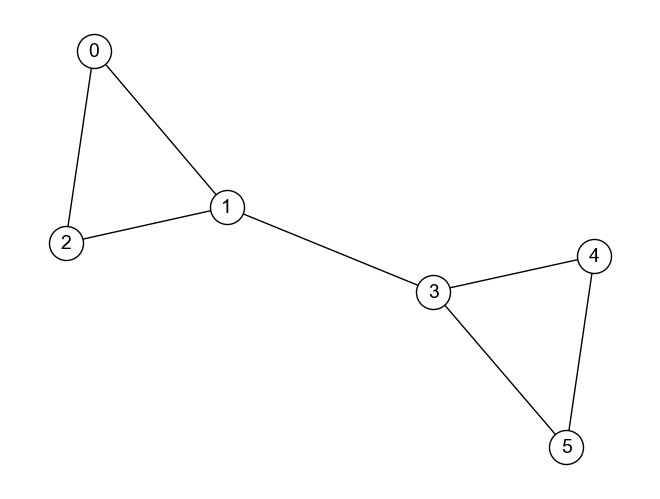

In [9]:
# グラフの定義
G_barbell = nx.Graph([
    (0, 1), (0, 2), (1, 2), (1, 3), (3, 4), (3, 5), (4, 5)
])

# 一応可視化
nx.draw(G_barbell, **DRAW_CONFIG)

# コミュニティを定義
communities = [{0, 1, 2}, {3, 4, 5}]

# モジュラリティの計算
nx.community.modularity(G_barbell, communities)

### Girvan-Newmanアルゴリズム

エッジの媒介中心性を基にグラフ分割を行う手続きは，[Girvan-Newmanアルゴリズム](https://en.wikipedia.org/wiki/Girvan%E2%80%93Newman_algorithm)として知られている．
Girvan-Newmanアルゴリズムの手順をまとめると，以下となる：

1. グラフ中の全エッジのエッジ媒介中心性を計算
2. 最大のエッジ媒介中心性をもつエッジを削除
3. 連結成分数やモジュラリティ値などが一定値を超えるまで，ステップ1-2を繰り返す
4. 得られた各連結成分をコミュニティとする

NetworkXでGirvan-Newmanアルゴリズムを実行するには，`community.girvan_newman`関数を用いる．
`community.girvan_newman`関数は，上記手順のステップ1-2をグラフ中のエッジがなくなるまで順次実行する．
以下は，グラフ$G_{nunchaku}$に対して`community.girvan_newman`関数を適用したコード例である．

1回目の分割結果 ({0, 1, 2}, {3, 4, 5, 6})
2回目の分割結果 ({0, 1, 2}, {4, 5, 6}, {3})
3回目の分割結果 ({0}, {1, 2}, {4, 5, 6}, {3})
4回目の分割結果 ({0}, {1}, {2}, {4, 5, 6}, {3})
5回目の分割結果 ({0}, {1}, {2}, {4}, {5, 6}, {3})
6回目の分割結果 ({0}, {1}, {2}, {4}, {5}, {6}, {3})


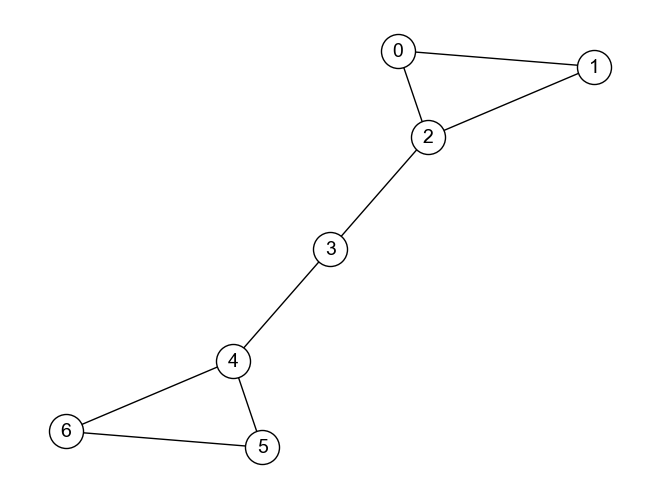

In [10]:
# グラフの定義
G_nunchaku = nx.barbell_graph(3, 1)

# 一応可視化
nx.draw(G_nunchaku, **DRAW_CONFIG)

# ループを回すごとにグラフ分割を行い，その結果を得ることができる
for i, communities in enumerate(nx.community.girvan_newman(G_nunchaku)):
    print(f"{i+1}回目の分割結果",  communities)

## リンクコミュニティ

これまで説明したグラフ分割によるコミュニティ発見手法では，グラフ中のノードは最終的にはいくつかあるコミュニティ（部分グラフ）のいずれか1つに所属することになる．
すなわち，各ノードは1つのコミュニティにしか所属できないことを意味する．
ノードが所属するコミュニティは1つに限定すると，アルゴリズム的にはすっきりする．
しかしながら，現実世界では所属するコミュニティが1つしかないことは稀であり，エンティティが複数のコミュニティに属していることは一般的である．
ゆえに，グラフ分析においても，ノードが複数のコミュニティに属することを認めるコミュニティ発見手法が必要である．

グラフ分割のアプローチ（Girvan-Newman法など）はノードに焦点を当ててコミュニティ分類を行うため，ノードを複数コミュニティに同時に割り当てることが難しかった．
これに対する解決策の1つが，**リンクコミュニティ（link community）** 発見である．

リンクコミュニティ発見とは，グラフをノード単位でコミュニティ発見するのではなく，エッジ（リンク）単位でコミュニティ発見し，その後，各コミュニティにノードを割り当てるアプローチを採る手法である．

例えば，以下の図のグラフを考えてみよう．
何らかの方法でノード間の各エッジがどのコミュニティに属するかの割り当てが完了しているとする．
また，あるエッジの所属コミュニティがXのとき，そのエッジの両端にあるノードはコミュニティXに属すると考える．
さて，グラフの真ん中に位置するノードはコミュニティAに属するエッジ，コミュニティBに属するエッジ，コミュニティCに属するエッジを持っている．
そのため，真ん中のノードはコミュニティA，B，Cの3つに属することになる．
エッジはどれか1つのコミュニティにしか属せないが，ノードは複数のコミュニティに属することができる．
このような考え方が，リンクコミュニティに着目したコミュニティ発見である．

![](img/link-community.jpg)

以下，リンクコミュニティの発見の手順である：
1. グラフ中の全エッジ間の類似度を計算する
2. エッジ類似度を基にエッジ集合に階層的クラスタリングを適用する
3. エッジの両端のノードにエッジのクラスタ番号を割り当てる

この方法では，汎用機械学習手法のひとつである階層的クラスタリングを用いている．
ポイントはエッジ類似度の定義である．

エッジ類似度の定義は様々なものが考えられるが，シンプルな定義はジャカード係数を用いるものである．
片端のノードが共通するエッジ$e_{i,k}$と$e_{j,k}$が与えられたとき，エッジ類似度$sim_{link}(e_{i, k}, e_{j, k})$を以下のように定義する：

$$
sim_{link}(e_{i, k}, e_{j, k}) = \frac{|n_+(i) \cap n_+(j)|}{|n_+(i) \cup n_+(j)|}
$$

ここで，$n_+(x)$はノード$x$とそれに隣接するノードの集合，$|X|$は集合$X$の要素数を表す．
なお，2つのエッジが与えられたとき，エッジの端にあるノードが1つも共通（共有）していないとき，エッジ間の類似度はゼロとする．

![](img/edge-similarity.jpg)


上の図のグラフを例にエッジ類似度を計算してみよう．
今，ノード5と8をつなぐエッジ$e_{8,5}$とノード5と1をつなぐエッジ$e_{1,5}$の類似度を計算することを考える．
2つのエッジはノード5を共有しているので，もう片側のノードに着目する．
ノード8に隣接するノードは1，2，5の3つであり，$n_+(8)=\{1, 2, 5, 8\}$
一方，ノード1に隣接するノードは2，3，4，5，8の5つであり，$n_+(1)=\{1, 2, 3, 4, 5, 8\}$．
よって，エッジ$e_{8,5}$とエッジ$e_{1,5}$の類似度は

$$
\begin{eqnarray}
sim_{link}(e_{8, 5}, e_{1, 5}) &= \frac{|n_+(8) \cap n_+(1)|}{|n_+(8) \cup n_+(1)|} \\
&=\frac{4}{6}
\end{eqnarray}
$$

となる．
同様にすべてのエッジ間の類似度を計算した後は，階層的クラスタリングによってエッジをクラスタリングする．

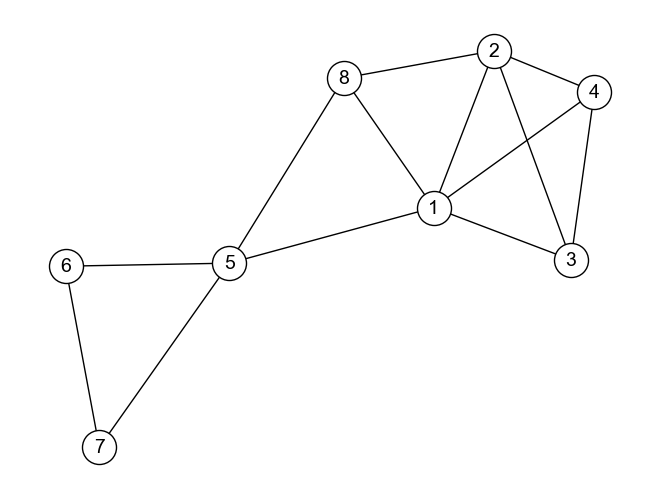

In [11]:
G_community = nx.Graph([
    (1, 2), (1, 3), (1, 4), (1, 5),
    (2, 3), (2, 4),
    (3, 4),
    (5, 6), (5, 7), (5, 8),
    (6, 7),
    (8, 2), (8, 1)
])

pos = nx.spring_layout(G_community, seed=123)
nx.draw(G_community, pos, **DRAW_CONFIG)

例として，上のグラフ$G$にリンクコミュニティ発見の手法を適用し，コミュニティ抽出を行ってみよう．
ちなみに，クラスタ間距離の定義に何を用いても構わないが，ここでは最長距離法（complete linkage）を用いることにする．

以下は，すべてのエッジ間の類似度を計算した後，`scipy`ライブラリの`linkage`関数を使って階層的クラスタリングを行い，クラスタリング結果のデンドログラムを表示するコードである（類似度の計算のコードが汚い）．

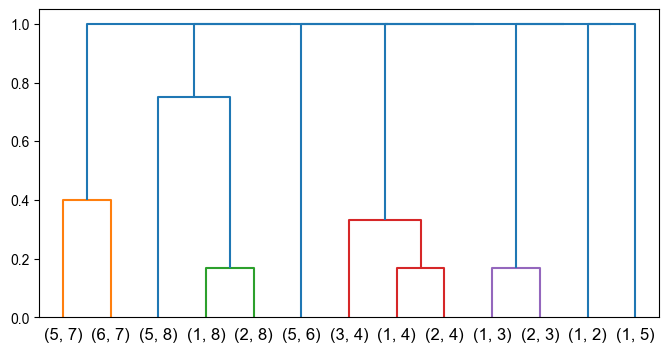

In [12]:
# 階層的クラスタリング用の関数
from scipy.cluster.hierarchy import linkage, dendrogram

# linkage関数に入力する距離行列を整形する関数 
from scipy.spatial.distance import squareform

# 可視化調整用ライブラリ
import matplotlib.pyplot as plt


# グラフの定義
G_community = nx.Graph([
    (1, 2), (1, 3), (1, 4), (1, 5),
    (2, 3), (2, 4),
    (3, 4),
    (5, 6), (5, 7), (5, 8),
    (6, 7),
    (8, 2), (8, 1)
])

# 計算対象となるエッジ
edges = list(G_community.edges())

# 距離（1 - 類似度）を格納する行列をゼロで初期化しておく
dist = np.zeros((len(edges), len(edges)))

# すべてのエッジ間の類似度を総当たりで計算
for i, e_i in enumerate(edges):
    for j, e_j in enumerate(edges):
        # 同一エッジの類似度は1，距離はゼロと見なす
        if e_i == e_j:
            dist[i, j] = 0
        else:
            # エッジiの左端ノードとエッジjの左端ノードが共通しているとき
            if e_i[0] == e_j[0]:
                nodes_plus_i = set(G_community.neighbors(e_i[1])) | {e_i[1]}
                nodes_plus_j = set(G_community.neighbors(e_j[1])) | {e_j[1]}
                sim = len(nodes_plus_i & nodes_plus_j) / len(nodes_plus_i | nodes_plus_j)
                dist[i, j] = 1 - sim
            # エッジiの左端ノードとエッジjの右端ノードが共通しているとき
            elif e_i[0] == e_j[1]:
                nodes_plus_i = set(G_community.neighbors(e_i[1])) | {e_i[1]}
                nodes_plus_j = set(G_community.neighbors(e_j[0])) | {e_j[0]}
                sim = len(nodes_plus_i & nodes_plus_j) / len(nodes_plus_i | nodes_plus_j)
                dist[i, j] = 1 - sim
            # エッジiの右端ノードとエッジjの左端ノードが共通しているとき
            if e_i[1] == e_j[0]:
                nodes_plus_i = set(G_community.neighbors(e_i[0])) | {e_i[0]}
                nodes_plus_j = set(G_community.neighbors(e_j[1])) | {e_j[1]}
                sim = len(nodes_plus_i & nodes_plus_j) / len(nodes_plus_i | nodes_plus_j)
                dist[i, j] = 1 - sim
            # エッジiの右端ノードとエッジjの右端ノードが共通しているとき
            if e_i[1] == e_j[1]:
                nodes_plus_i = set(G_community.neighbors(e_i[0])) | {e_i[0]}
                nodes_plus_j = set(G_community.neighbors(e_j[0])) | {e_j[0]}
                sim = len(nodes_plus_i & nodes_plus_j) / len(nodes_plus_i | nodes_plus_j)
                dist[i, j] = 1 - sim                   
            else:
                dist[i, j] = 1

        dist[j, i] = dist[i, j]


# 距離行列を整形
pdist = squareform(dist)

# 最長距離法（complete linkage）を用いた階層的クラスタリング
clustering_result = linkage(pdist, 'complete')


# デンドログラムの可視化
plt.rcParams["font.family"] = "Arial" # フォントの設定
plt.figure(figsize=(8, 4)) # 図の大きさの設定
fig = dendrogram(clustering_result, labels=edges)
plt.show()

上記のようなデンドログラムが得られた．
適当な高さでデンドログラムを切り，エッジをクラスタに分け，エッジのクラスタに応じてノードにもクラスタを割り当てたのが以下の図である．
ノード1，2，5が複数のクラスタに割り当てられており，ノードが複数のコミュニティに属することを認めるコミュニティを発見することができた．

![](img/link-community-detection.jpg)

---

## クイズ

### Q1. 空手クラブを2派閥に分ける

以下のグラフ$G_{karate}$は，ある大学の空手クラブに所属する人物をノード，人物間の交友関係をエッジとして表現したものである（[参考](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)）．
この空手クラブでは，インストラクター（Mr. Hi）（ノード0）とクラブ会長（ノード33）の仲が悪く，空手クラブの所属者はインストラクター派閥と会長派閥に別れている．

グラフ$G_{karate}$においてエッジ媒介中心性が最大となるエッジを順次削除し，グラフの連結成分数が2になった時点でのグラフを表示しなさい．
ただし，このクイズではNetworkXの`community.girvan_newman`関数は使わないこと．

※ ヒント: グラフ$G$上のノード$x$とノード$y$の間のエッジを切断するには，`G.remove_edge(x, y)`とすればよい．

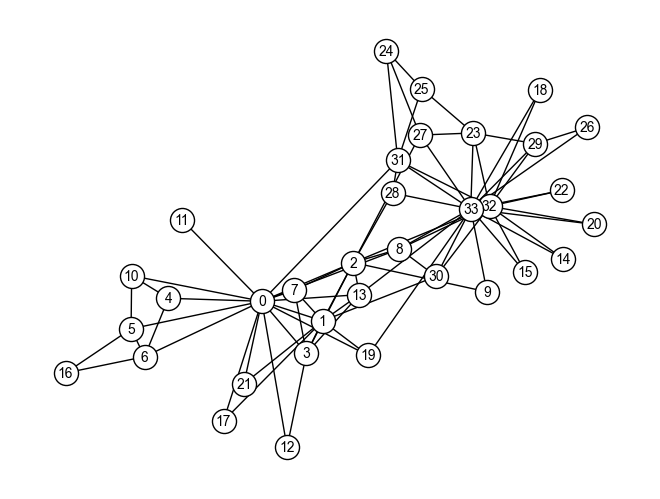

In [5]:
SECRET_KARATE_DRAW_CONFIG = {
    'node_color': 'white',
    'edgecolors': 'black', # line color of nodes
    'with_labels': True,
    'node_size': 300,
    'font_size': 10,
    'font_family': 'Arial',
}

G_karate = nx.karate_club_graph()
pos = nx.spring_layout(G_karate, seed=123)
nx.draw(G_karate, pos, **SECRET_KARATE_DRAW_CONFIG)

In [6]:
import networkx as nx

# グラフの定義
G_karate = nx.karate_club_graph()

# Write your codes below

### Q2. Girvan-Newmanアルゴリズムとモジュラリティ

Q1で用いたグラフ$G_{karate}$にGirvan-Newmanアルゴリズムを適応し，分割できなくなるまでグラフをコミュニティに分割しなさい．
また，コミュニティ分割をする度にグラフのモジュラリティを計算し，モジュラリティの変化値を観察しなさい．
さらに，モジュラリティが最大となるコミュニティ分割の結果を示しなさい．

In [7]:
# グラフの定義
G_karate = nx.karate_club_graph()

# Write your codes below